In [89]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras as kb
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.models import load_model
import matplotlib.pyplot as plt
import visualkeras

In [35]:
# Define the path to the CFD image directory
path_to_cfd_images = r'C:\Users\kyleb\Downloads\cfd\CFD Version 3.0\Images\CFD'

# Define the path to the CSV file
path_to_csv_file = r'C:\Users\kyleb\Downloads\FinalProjectDF.csv'

In [36]:
# Load the CSV file into a pandas dataframe
df = pd.read_csv(path_to_csv_file)

# Define a function to identify all the JPEG files in a directory and its subdirectories
def find_jpg_files(path):
    jpg_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg'):
                jpg_files.append(os.path.join(root, file))
    return jpg_files

# Use the find_jpg_files function to get a list of all JPEG files in the CFD image directory
jpg_files = find_jpg_files(path_to_cfd_images)

# Loop through each JPEG file and add its path to the "path" column of the corresponding row in the dataframe
for jpg_file in jpg_files:
    # Extract the subject ID from the file path
    subject_id = os.path.basename(os.path.dirname(jpg_file))
    # Find the row in the dataframe corresponding to the subject ID
    row_index = df.index[df['ID'] == subject_id][0]
    # Add the file path to the "path" column of the corresponding row
    df.at[row_index, 'path'] = jpg_file

# Convert gender column to binary labels. 0 for F, 1 for M
# df["Gender"] = df["Gender"].apply(lambda x: 1 if x == "M" else 0)
df.head()

,ID,Gender,Age,AttractiveScore,path
0,AF-200,F,33,4.111111,C:\Users\kyleb\Downloads\cfd\CFD Version 3.0\I...
1,AF-201,F,24,3.111111,C:\Users\kyleb\Downloads\cfd\CFD Version 3.0\I...
2,AF-202,F,24,3.000000,C:\Users\kyleb\Downloads\cfd\CFD Version 3.0\I...
3,AF-203,F,23,3.275862,C:\Users\kyleb\Downloads\cfd\CFD Version 3.0\I...
4,AF-204,F,30,3.172414,C:\Users\kyleb\Downloads\cfd\CFD Version 3.0\I...


In [37]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2)

# Define input shape
input_shape = (400, 400, 3) # assuming images are 100x100 pixels with 3 color channels

# Define the CNN architecture
gender_model = Sequential()
gender_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
gender_model.add(MaxPooling2D(pool_size=(2, 2)))
gender_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
gender_model.add(MaxPooling2D(pool_size=(2, 2)))
gender_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
gender_model.add(MaxPooling2D(pool_size=(2, 2)))
gender_model.add(Flatten())
gender_model.add(Dense(256, activation="relu"))
gender_model.add(Dense(1, activation="sigmoid"))

# Compile the model
gender_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Define the image generator for loading images from disk
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create a generator for loading training images from the dataframe
train_data_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="Gender",
    target_size=(400, 400),
    batch_size=batch_size,
    class_mode="binary"
)

# Create a generator for loading testing images from the dataframe
test_data_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="Gender",
    target_size=(400, 400),
    batch_size=batch_size,
    class_mode="binary"
)

Found 477 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.


In [38]:
# Train the model
history = gender_model.fit(train_data_generator, epochs=10, validation_data=test_data_generator)

# Evaluate the model
loss, accuracy = gender_model.evaluate(test_data_generator)
print("Accuracy:", accuracy)

Epoch 1/10
15/15 [==============================] - 81s 5s/step - loss: 2.9181 - accuracy: 0.5388 - val_loss: 0.6011 - val_accuracy: 0.7250
Epoch 2/10
15/15 [==============================] - 63s 4s/step - loss: 0.5984 - accuracy: 0.6520 - val_loss: 0.4505 - val_accuracy: 0.8167
Epoch 3/10
15/15 [==============================] - 64s 4s/step - loss: 0.4432 - accuracy: 0.7925 - val_loss: 0.3500 - val_accuracy: 0.8583
Epoch 4/10
15/15 [==============================] - 65s 4s/step - loss: 0.3091 - accuracy: 0.8784 - val_loss: 0.3052 - val_accuracy: 0.9000
Epoch 5/10
15/15 [==============================] - 64s 4s/step - loss: 0.2326 - accuracy: 0.9161 - val_loss: 0.1599 - val_accuracy: 0.9417
Epoch 6/10
15/15 [==============================] - 64s 4s/step - loss: 0.1713 - accuracy: 0.9287 - val_loss: 0.3177 - val_accuracy: 0.8583
Epoch 7/10
15/15 [==============================] - 66s 4s/step - loss: 0.1200 - accuracy: 0.9560 - val_loss: 0.2067 - val_accuracy: 0.9000
Epoch 8/10
15/15 [==

In [39]:
# Save the model to a file
gender_model.save('gender_model.h5')

In [72]:
gender_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 199, 199, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 197, 197, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 98, 98, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 48, 48, 128)     

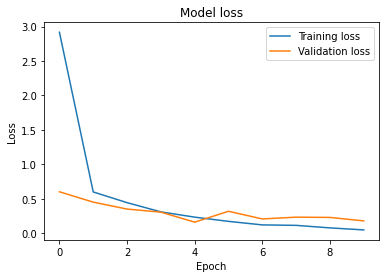

In [41]:
# Plot the training loss and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

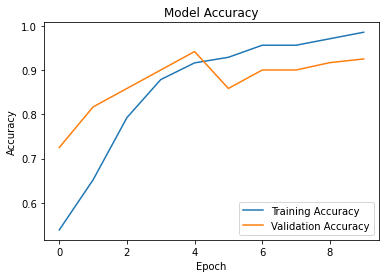

In [43]:
# Plot the training accuracy and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()


In [ ]:
# # Define the CNN architecture
# male_model = Sequential()

# male_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# male_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.05)))
# male_model.add(MaxPooling2D(pool_size=(2, 2)))
# male_model.add(Dropout(0.25))

# male_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.05)))
# male_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.05)))
# male_model.add(MaxPooling2D(pool_size=(2, 2)))
# male_model.add(Dropout(0.25))

# male_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.05)))
# male_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.05)))
# male_model.add(MaxPooling2D(pool_size=(2, 2)))
# male_model.add(Dropout(0.25))

# male_model.add(Flatten())
# male_model.add(Dense(512, activation='relu'))
# male_model.add(Dropout(0.5))
# male_model.add(Dense(256, activation='relu'))
# male_model.add(Dropout(0.5))
# male_model.add(Dense(1, activation='linear'))

# male_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [49]:
# Filter for male images only
male_df = df[df["Gender"] == "M"].reset_index(drop=True)

# Split the data into training and testing sets
train_df, test_df = train_test_split(male_df, test_size=0.2)

# Define input shape
input_shape = (400, 400, 3) # assuming images are 100x100 pixels with 3 color channels

# Define the model
male_model = Sequential()

# Convolutional layers
male_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)))
male_model.add(Conv2D(32, (3, 3), activation='relu'))
male_model.add(MaxPooling2D(pool_size=(2, 2)))

male_model.add(Conv2D(64, (3, 3), activation='relu'))
male_model.add(Conv2D(64, (3, 3), activation='relu'))
male_model.add(MaxPooling2D(pool_size=(2, 2)))

male_model.add(Conv2D(128, (3, 3), activation='relu'))
male_model.add(Conv2D(128, (3, 3), activation='relu'))
male_model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
male_model.add(Flatten())
male_model.add(Dense(256, activation='relu'))
male_model.add(Dense(128, activation='relu'))
male_model.add(Dense(64, activation='relu'))
male_model.add(Dense(1, activation='linear'))

# Compile the model
male_model.compile(loss="mean_squared_error", optimizer="adam", metrics="mae")

# Define the image generator for loading images from disk
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create a generator for loading training images from the dataframe
train_data_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="AttractiveScore",
    target_size=(400, 400),
    batch_size=batch_size,
    class_mode="raw"
)

# Create a generator for loading testing images from the dataframe
test_data_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="AttractiveScore",
    target_size=(400, 400),
    batch_size=batch_size,
    class_mode="raw"
)

Found 232 validated image filenames.
Found 58 validated image filenames.


In [51]:
# Train the model
male_history = male_model.fit(train_data_generator, epochs=15, validation_data=test_data_generator)

# Evaluate the model
loss = male_model.evaluate(test_data_generator)
print("Mean Squared Error:", loss)

Epoch 1/15
8/8 [==============================] - 92s 11s/step - loss: 18.3273 - mae: 3.4429 - val_loss: 1.3804 - val_mae: 1.0182
Epoch 2/15
8/8 [==============================] - 83s 10s/step - loss: 0.7992 - mae: 0.7256 - val_loss: 1.0674 - val_mae: 0.8133
Epoch 3/15
8/8 [==============================] - 92s 11s/step - loss: 0.6179 - mae: 0.6210 - val_loss: 0.6144 - val_mae: 0.6295
Epoch 4/15
8/8 [==============================] - 85s 10s/step - loss: 0.4751 - mae: 0.5613 - val_loss: 0.5093 - val_mae: 0.5767
Epoch 5/15
8/8 [==============================] - 88s 11s/step - loss: 0.4735 - mae: 0.5477 - val_loss: 0.5390 - val_mae: 0.6060
Epoch 6/15
8/8 [==============================] - 82s 10s/step - loss: 0.4528 - mae: 0.5423 - val_loss: 0.5265 - val_mae: 0.5968
Epoch 7/15
8/8 [==============================] - 80s 10s/step - loss: 0.4983 - mae: 0.5546 - val_loss: 0.5403 - val_mae: 0.6092
Epoch 8/15
8/8 [==============================] - 82s 10s/step - loss: 0.4325 - mae: 0.5162 - va

In [75]:
# Save the model to a file
male_model.save('male_model.h5')

In [58]:
male_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 398, 398, 32)      896       
                                                                 
 conv2d_76 (Conv2D)          (None, 396, 396, 32)      9248      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 198, 198, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 196, 196, 64)      18496     
                                                                 
 conv2d_78 (Conv2D)          (None, 194, 194, 64)      36928     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 97, 97, 64)       0         
 g2D)                                                

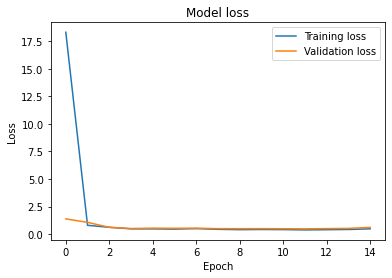

In [63]:
# Plot the training loss and validation loss over epochs
plt.plot(male_history.history['loss'])
plt.plot(male_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

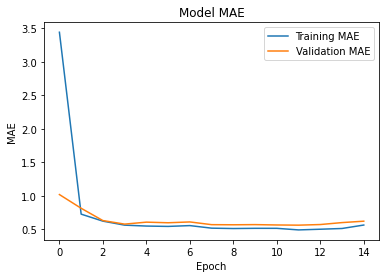

In [64]:
# Plot the training mae and validation mae over epochs
plt.plot(male_history.history['mae'])
plt.plot(male_history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training MAE', 'Validation MAE'], loc='upper right')
plt.show()

In [74]:
# Filter for female images only
female_df = df[df["Gender"] == "F"].reset_index(drop=True)

# Split the data into training and testing sets
train_df, test_df = train_test_split(female_df, test_size=0.2)

# Define input shape
input_shape = (400, 400, 3) # assuming images are 100x100 pixels with 3 color channels

# Define the model
female_model = Sequential()

# Convolutional layers
female_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)))
female_model.add(Conv2D(32, (3, 3), activation='relu'))
female_model.add(MaxPooling2D(pool_size=(2, 2)))

female_model.add(Conv2D(64, (3, 3), activation='relu'))
female_model.add(Conv2D(64, (3, 3), activation='relu'))
female_model.add(MaxPooling2D(pool_size=(2, 2)))

female_model.add(Conv2D(128, (3, 3), activation='relu'))
female_model.add(Conv2D(128, (3, 3), activation='relu'))
female_model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
female_model.add(Flatten())
female_model.add(Dense(256, activation='relu'))
female_model.add(Dense(128, activation='relu'))
female_model.add(Dense(64, activation='relu'))
female_model.add(Dense(1, activation='linear'))

female_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])


# Compile the model
female_model.compile(loss="mean_squared_error", optimizer="adam",metrics= "mae")

# Define the image generator for loading images from disk
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create a generator for loading training images from the dataframe
train_data_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="AttractiveScore",
    target_size=(400, 400),
    batch_size=batch_size,
    class_mode="raw"
)

# Create a generator for loading testing images from the dataframe
test_data_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="AttractiveScore",
    target_size=(400, 400),
    batch_size=batch_size,
    class_mode="raw"
)

Found 245 validated image filenames.
Found 62 validated image filenames.


In [76]:
# Train the model
female_history = female_model.fit(train_data_generator, epochs=15, validation_data=test_data_generator)

# Evaluate the model
loss = female_model.evaluate(test_data_generator)
print("Mean Squared Error:", loss)


Epoch 1/15
8/8 [==============================] - 105s 14s/step - loss: 141.7304 - mae: 6.4049 - val_loss: 0.7332 - val_mae: 0.7170
Epoch 2/15
8/8 [==============================] - 88s 11s/step - loss: 1.6399 - mae: 1.0456 - val_loss: 1.4950 - val_mae: 0.9927
Epoch 3/15
8/8 [==============================] - 91s 11s/step - loss: 1.2903 - mae: 0.9155 - val_loss: 0.9439 - val_mae: 0.7867
Epoch 4/15
8/8 [==============================] - 87s 11s/step - loss: 0.8037 - mae: 0.7256 - val_loss: 0.5900 - val_mae: 0.6335
Epoch 5/15
8/8 [==============================] - 84s 10s/step - loss: 0.6463 - mae: 0.6605 - val_loss: 0.6187 - val_mae: 0.6523
Epoch 6/15
8/8 [==============================] - 87s 11s/step - loss: 0.6236 - mae: 0.6610 - val_loss: 0.6283 - val_mae: 0.6471
Epoch 7/15
8/8 [==============================] - 86s 11s/step - loss: 0.6528 - mae: 0.6609 - val_loss: 0.6172 - val_mae: 0.6438
Epoch 8/15
8/8 [==============================] - 85s 11s/step - loss: 0.6479 - mae: 0.6604 - 

In [77]:
# Save the model to a file
female_model.save('female_model.h5')

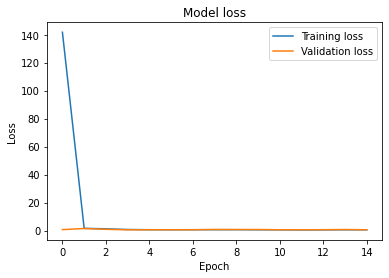

In [81]:
# Plot the training loss and validation loss over epochs
plt.plot(female_history.history['loss'])
plt.plot(female_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

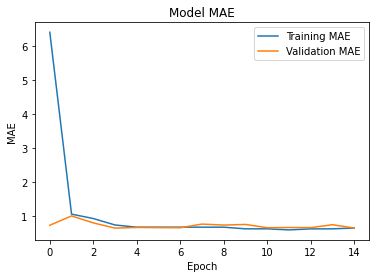

In [82]:
# Plot the training mae and validation mae over epochs
plt.plot(female_history.history['mae'])
plt.plot(female_history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training MAE', 'Validation MAE'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 98ms/step


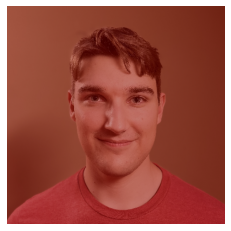

In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# Define a function to generate the Grad-CAM heatmap
def generate_heatmap(model, img_array, class_index):
    # Get the last convolutional layer of the model
    last_conv_layer = model.get_layer("conv2d_44")

    # Create a new model that outputs the last convolutional layer and the model's prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer.output, model.output]
    )

    # Get the gradient of the predicted class with respect to the output feature map of the last convolutional layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_output)

    # Compute the global average of the gradients across all feature maps
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the weighted sum of the feature maps with the gradients
    last_conv_output = conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

# Load the test image
img_path = r"C:\Users\kyleb\Downloads\IMG-5298.jpg"
img = load_img(img_path, target_size=(400, 400))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Load the model
model = gender_model
# Get the predicted class index
preds = model.predict(img_array)
class_index = np.argmax(preds[0])

# Generate the heatmap
heatmap = generate_heatmap(model, img_array, class_index)

# Resize the heatmap to the original image size
heatmap = cv2.resize(heatmap, (400, 400))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Convert the image to a numpy array
img_array = img_to_array(img).astype("uint8")

# Overlay the heatmap on the original image
overlay = cv2.addWeighted(img_array, 0.5, heatmap, 0.5, 0)

# Show the heatmap
fig, ax = plt.subplots()
ax.imshow(overlay)
ax.axis("off")
plt.show()

In [ ]:
for i in df.iloc[0]:
    print(i)

In [122]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the new image
#Kyle
# img_path = r"C:\Users\kyleb\Downloads\IMG-0895.jpg"
#Connor
# img_path = r"C:\Users\kyleb\Downloads\IMG-5298.jpg"
#Ponthea
# img_path = r"C:\Users\kyleb\Downloads\IMG-5300.jpg"
#Gil
img_path = r"C:\Users\kyleb\Downloads\IMG-5301.jpg"



img = load_img(img_path, target_size=(400, 400))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)
img_array = img_array / 255.0

# Predict the gender
gender_pred = gender_model.predict(img_array)
print("Probability Male:",round(gender_pred[0][0],3))
gender = "M" if gender_pred > 0.5 else "F"
if (gender == "M"):
    # Predict the attractiveness
    attractiveness_pred = male_model.predict(img_array)
    attractiveness = attractiveness_pred[0][0]
else:
    # Predict the attractiveness
    attractiveness_pred = female_model.predict(img_array)
    attractiveness = attractiveness_pred[0][0]


print("Attractiveness \nPrediction:", round(attractiveness,3))

1/1 [==============================] - 0s 146ms/step
Probability Male: 0.0
1/1 [==============================] - 0s 211ms/step
Attractiveness 
Prediction: 2.596
